In [4]:
##################################################################
#
# QBPrimeAgeModel.ipynb
#
# Description: Train a polynomial regression model that represents
#   the prime age of a QB with respect to fantasy value.
# Author: Ken Reeser
# Since: 2018-08-28
#
##################################################################

%matplotlib inline
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import sys, os
import boto3

sys.path.append('.\\app\\util')
from FantasyFootballOffense import calc_past_offensive_fantasy_values

statDict = dict()
seasonsList = list()

#1. Get the game stats for each QB for every year they have played
s3 = boto3.resource('s3')
try:
    gamesObj = s3.Object('fantasyfootballdata', 'games_QB_train.json')
    gamesDf = pd.read_json(gamesObj.get()['Body'].read().decode('utf-8'))
    gamesDf.sort_values(by=['player_id'])

except botocore.exceptions.ClientError as e:
    # If a client error is thrown, then check that it was a 404 error.
    # If it was a 404 error, then the bucket does not exist.
    error_code = int(e.response['Error']['Code'])
    print(error_code)

#2. Loop through QB player_id's and calculate fantasy values
#3. Record the number of seasons played for lifespan study of the QB position
for player_id in gamesDf.player_id.unique():
    career = gamesDf.loc[gamesDf.player_id == player_id]
    if career is not None and len(career) > 0:
        seasons = calc_past_offensive_fantasy_values(career)
        if(len(seasons) > 0):
            statDict[player_id] = seasons
            seasonsList.append(len(seasons))


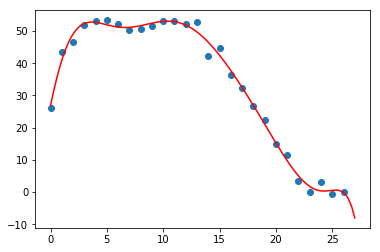

In [5]:
#4. Perform lifespan study for the QB position; then comment this out.
#plt.hist(seasonsList, bins=26)
#plt.xticks(np.arange(0, 26, step=1))
#plt.show()

#5. Calculate the prime age curve for the QB position
statDfNoFill = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in statDict.items()]))
statDfWithFill = statDfNoFill.fillna(0)
statDfWithFill['averageWithFill'] = statDfWithFill.mean(axis=1)
statDfWithFill['averageNoFill'] = statDfNoFill.mean(axis=1)
statDfWithFill['averageOverall'] = (statDfWithFill['averageWithFill'] + statDfWithFill['averageNoFill']) / 2
statDfWithFill.to_csv(".\\qb_fantasy_values.csv", index=False, encoding='utf8')

#6. Test different orders of the polymonmial regression to determine best fit
p9 = np.poly1d(np.polyfit(np.arange(0,27,1), statDfWithFill['averageOverall'], 9))
xp = np.linspace(0,27,100)
plt.scatter(np.arange(0,27,1), statDfWithFill['averageOverall'])
plt.plot(xp, p9(xp), c='r')
plt.show()

In [6]:
from sklearn.metrics import r2_score

r2 = r2_score(statDfWithFill['averageOverall'], p9(np.arange(0,27,1)))

print(r2)

0.9932818378892265


C:\Users\kjree\Anaconda3\envs\fantasyfootballenv\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\kjree\Anaconda3\envs\fantasyfootballenv\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\kjree\Anaconda3\envs\fantasyfootballenv\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\kjr

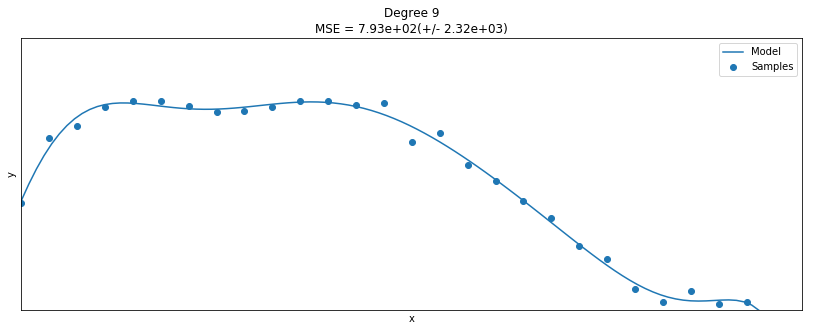

Model is SAVED!


In [7]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation

#7. Use scikit-learn PolynomialFeatures and cross validation to create the model
np.random.seed(0)
n_samples = 30
degrees = [9]
X = np.arange(0.0,27.0,1.0)
y = np.array(statDfWithFill['averageOverall'])
next_draft_of_model = None

#8. Evaluate the models using crossvalidation
plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)
    
    next_draft_of_model = pipeline

    scores = cross_validation.cross_val_score(pipeline,
        X[:, np.newaxis], y, scoring="mean_squared_error", cv=10)

    X_test = np.linspace(0, 27, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.scatter(X, y, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 28))
    plt.ylim((-2, 70))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(degrees[i], -scores.mean(), scores.std()))
plt.show()

#9. Save the QB prime age model to disk
filename = ".\\app\\data\\qb_prime_age_model.pkl"
pickle.dump(next_draft_of_model, open(filename, 'wb'))
print("Model is SAVED!")
    
#10. Aspect B of the NFL Player Model:
# Group all QB's into top 0-20%,21-40%,41-60%,61-80%, and 81-100% based on last year's fantasy values
#qbLastYearStatDict = dict()
#for key in qbCareerDict.keys():
#    career = qbCareerDict[key]
#    if career is not None and len(career) > 0:
#        lastYear = calcPastFantasyPointValue(career, 2017)
#        if lastYear is not None:
#            qbLastYearStatDict[key] = lastYear